In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import DualwormFunctions as dw
import Observables as obs

#%load_ext line_profiler
#%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#import yep

In [3]:
nst = 256
nsm = 512
nips = 32;
nrps = 8;
nb = 64
measperiod =2;
nt = 32
nh = 1
ncores = 8
nmaxiter = 1
L = 12
J1 = 1
J2 = 0
h = 0
measupdate = True
htip =2 # when v = v1, p = htip/J. Values to try: 0, 2, 4
ttip = 0
version = 4
pswitch = 0.4
uponly = True
if not measupdate:
    htip = 0

stroutput =\
"PSIMeasupdate_Tests_J1={0}_L={1}_htip={2}_ttip={3}_pswitch={4}_uponly={5}_version={6}".format(J1,
                                                                                               L,
                                                                                               htip,
                                                                                               ttip,
                                                                                               pswitch,
                                                                                               uponly,
                                                                                               version)

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = 0.0,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = False, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = 'JustSomeJ1-1J21J31Test2_step1_folder',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = measupdate, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--measupdatev', type = int, default = version,
                       help = '''select the version of measupdate''')
    parser.add_argument('--htip', type = float, default = htip, 
                       help = '''magnetic field associated with the tip''')
    parser.add_argument('--Ttip', type = float, default = ttip, 
                       help = '''temperature associated with the tip measurements''')
    parser.add_argument('--pswitch', type = float, default = pswitch, 
                       help = '''tip switching probability''')
    parser.add_argument('--uponly', type = float, default = uponly, 
                       help = '''Only switching down spins to up spins in measupdate''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = False, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = True, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.1,60],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = False, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = True, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = True, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--frustratedT', default = True, action = 'store_true',
                        help = 'activate if you want to save the frustrated triangles')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--both', default = True, action = 'store_true',
                        help = '''activate if you want to save both types of correlations''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    parser.add_argument('--sref0', nargs = '+', type = int, default = [L-2, L-1, 0], help = 'ref spin 0')
    parser.add_argument('--sref1', nargs = '+', type = int, default = [L-2, L-1, 1], help = 'ref spin 1')
    parser.add_argument('--sref2', nargs = '+', type = int, default = [L-2, L-1, 2], help = 'ref spin 2')
    
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose',default = False, action = 'store_true',
                        help = 'activate verbosity')
    args = parser.parse_args()
    return args



In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
#%lprun -f dw.mcs_swaps 
[meanstat, swapst, swapsh, failedupdatesth, failedupdates, failedssfupdates] = callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./PSIMeasupdate_Tests_J1=1_L=8_htip=2_ttip=0_pswitch=0.4_uponly=True_version=4_folder/backup.hkl
Lattice side size:  8
J1  1
J2  0
J3  0.0
J3st  0.0
Couplings extracted
Hamiltonian expression (without field) computed
alternating ssf and dw update
Number of temperatures:  32
Temperatures: [ 0.1         0.12291865  0.15108995  0.18571772  0.22828172  0.2806008
  0.34491072  0.4239596   0.52112542  0.64056033  0.78736811  0.96782226
  1.18963405  1.46228212  1.79741744  2.20936126  2.71571703  3.33812272
  4.10317539  5.0435678   6.19948545  7.62032384  9.3667992  11.51354313
 14.1522918  17.39580604 21.38268997 26.28331387 32.30709462 39.7114446
 48.81277165 60.        ]
Number of magnetic fields:  1
Magnetic fields:  [0.]
Fully random initialisation =  True
Identical initialisation =  False
Magnetisation initialisation =  False
Minimal energy index:  0  with energy per site  -0.6666666666666666
RunBasis: Away from gs at t index  0
  

In [7]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [8]:
import importlib
importlib.reload(af)

<module 'AnalysisFunctions' from '/home/jcolbois/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py'>

In [9]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, 
 htip, Ttip, pswitch, uponly, path,
 temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh, 
 stat_hfields, hfields_plots, listfunctions, sref, ids2walker] =\
af.LoadParameters(foldername, filenamelist)

[-0.66666667]


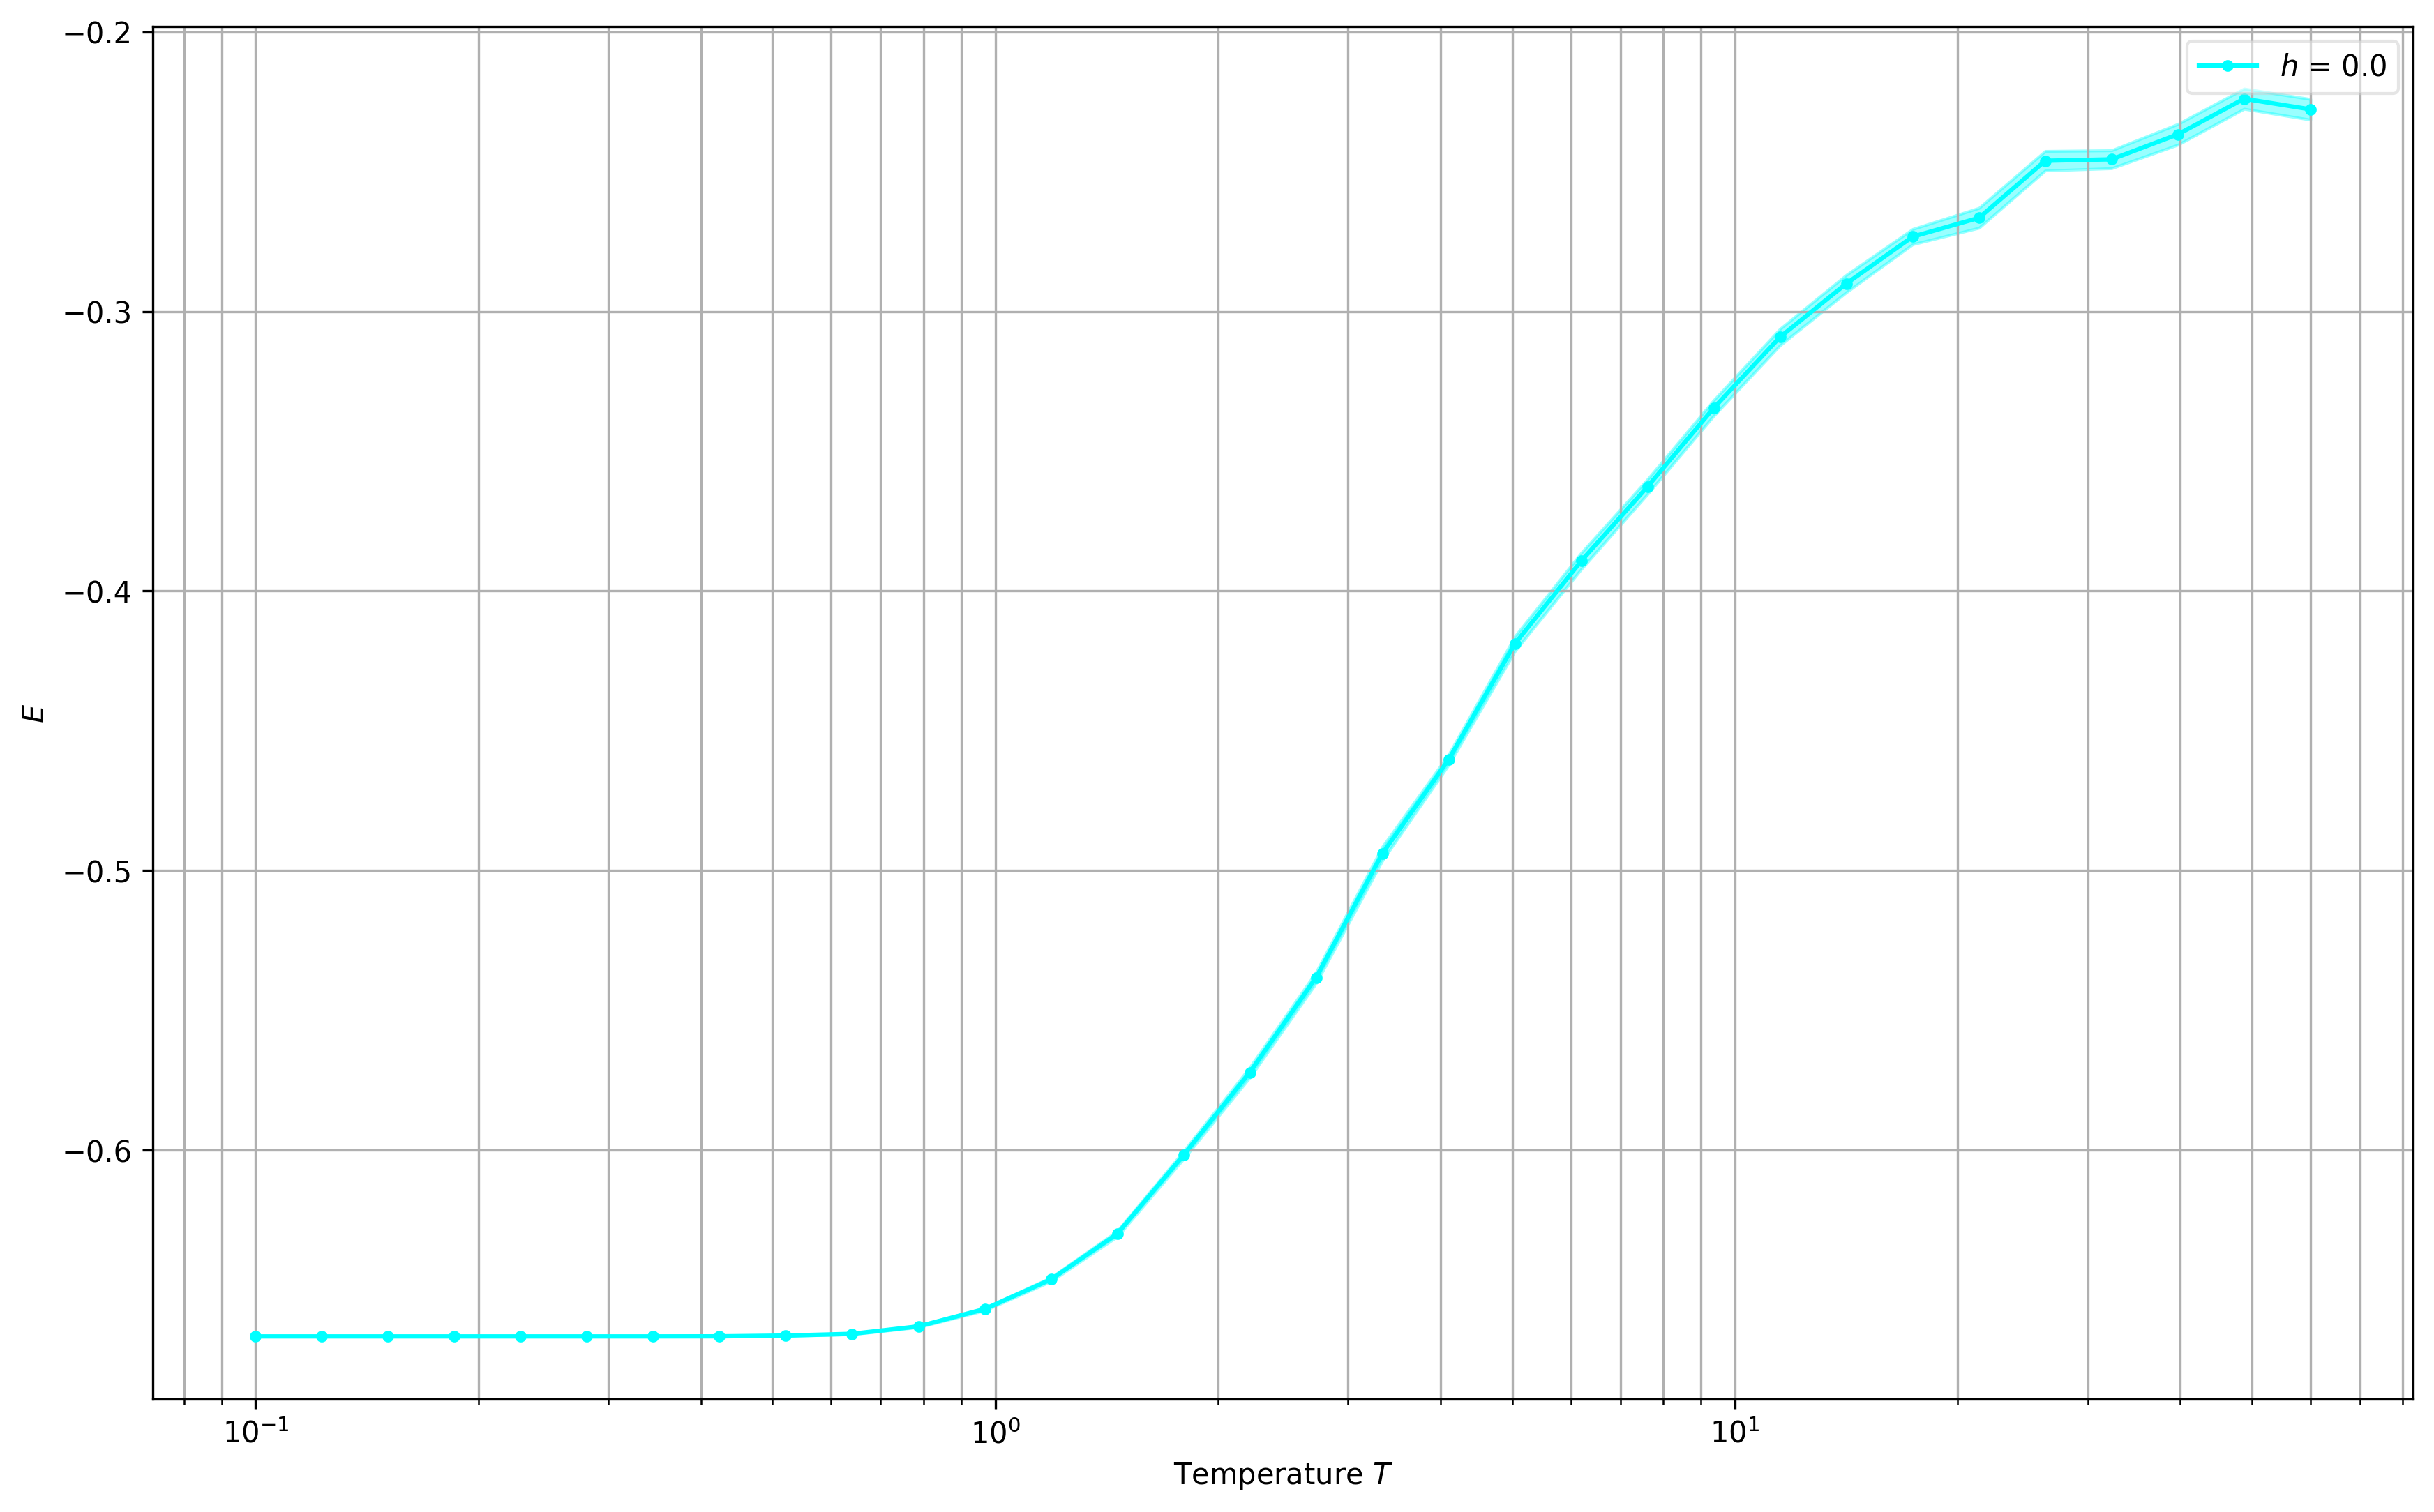

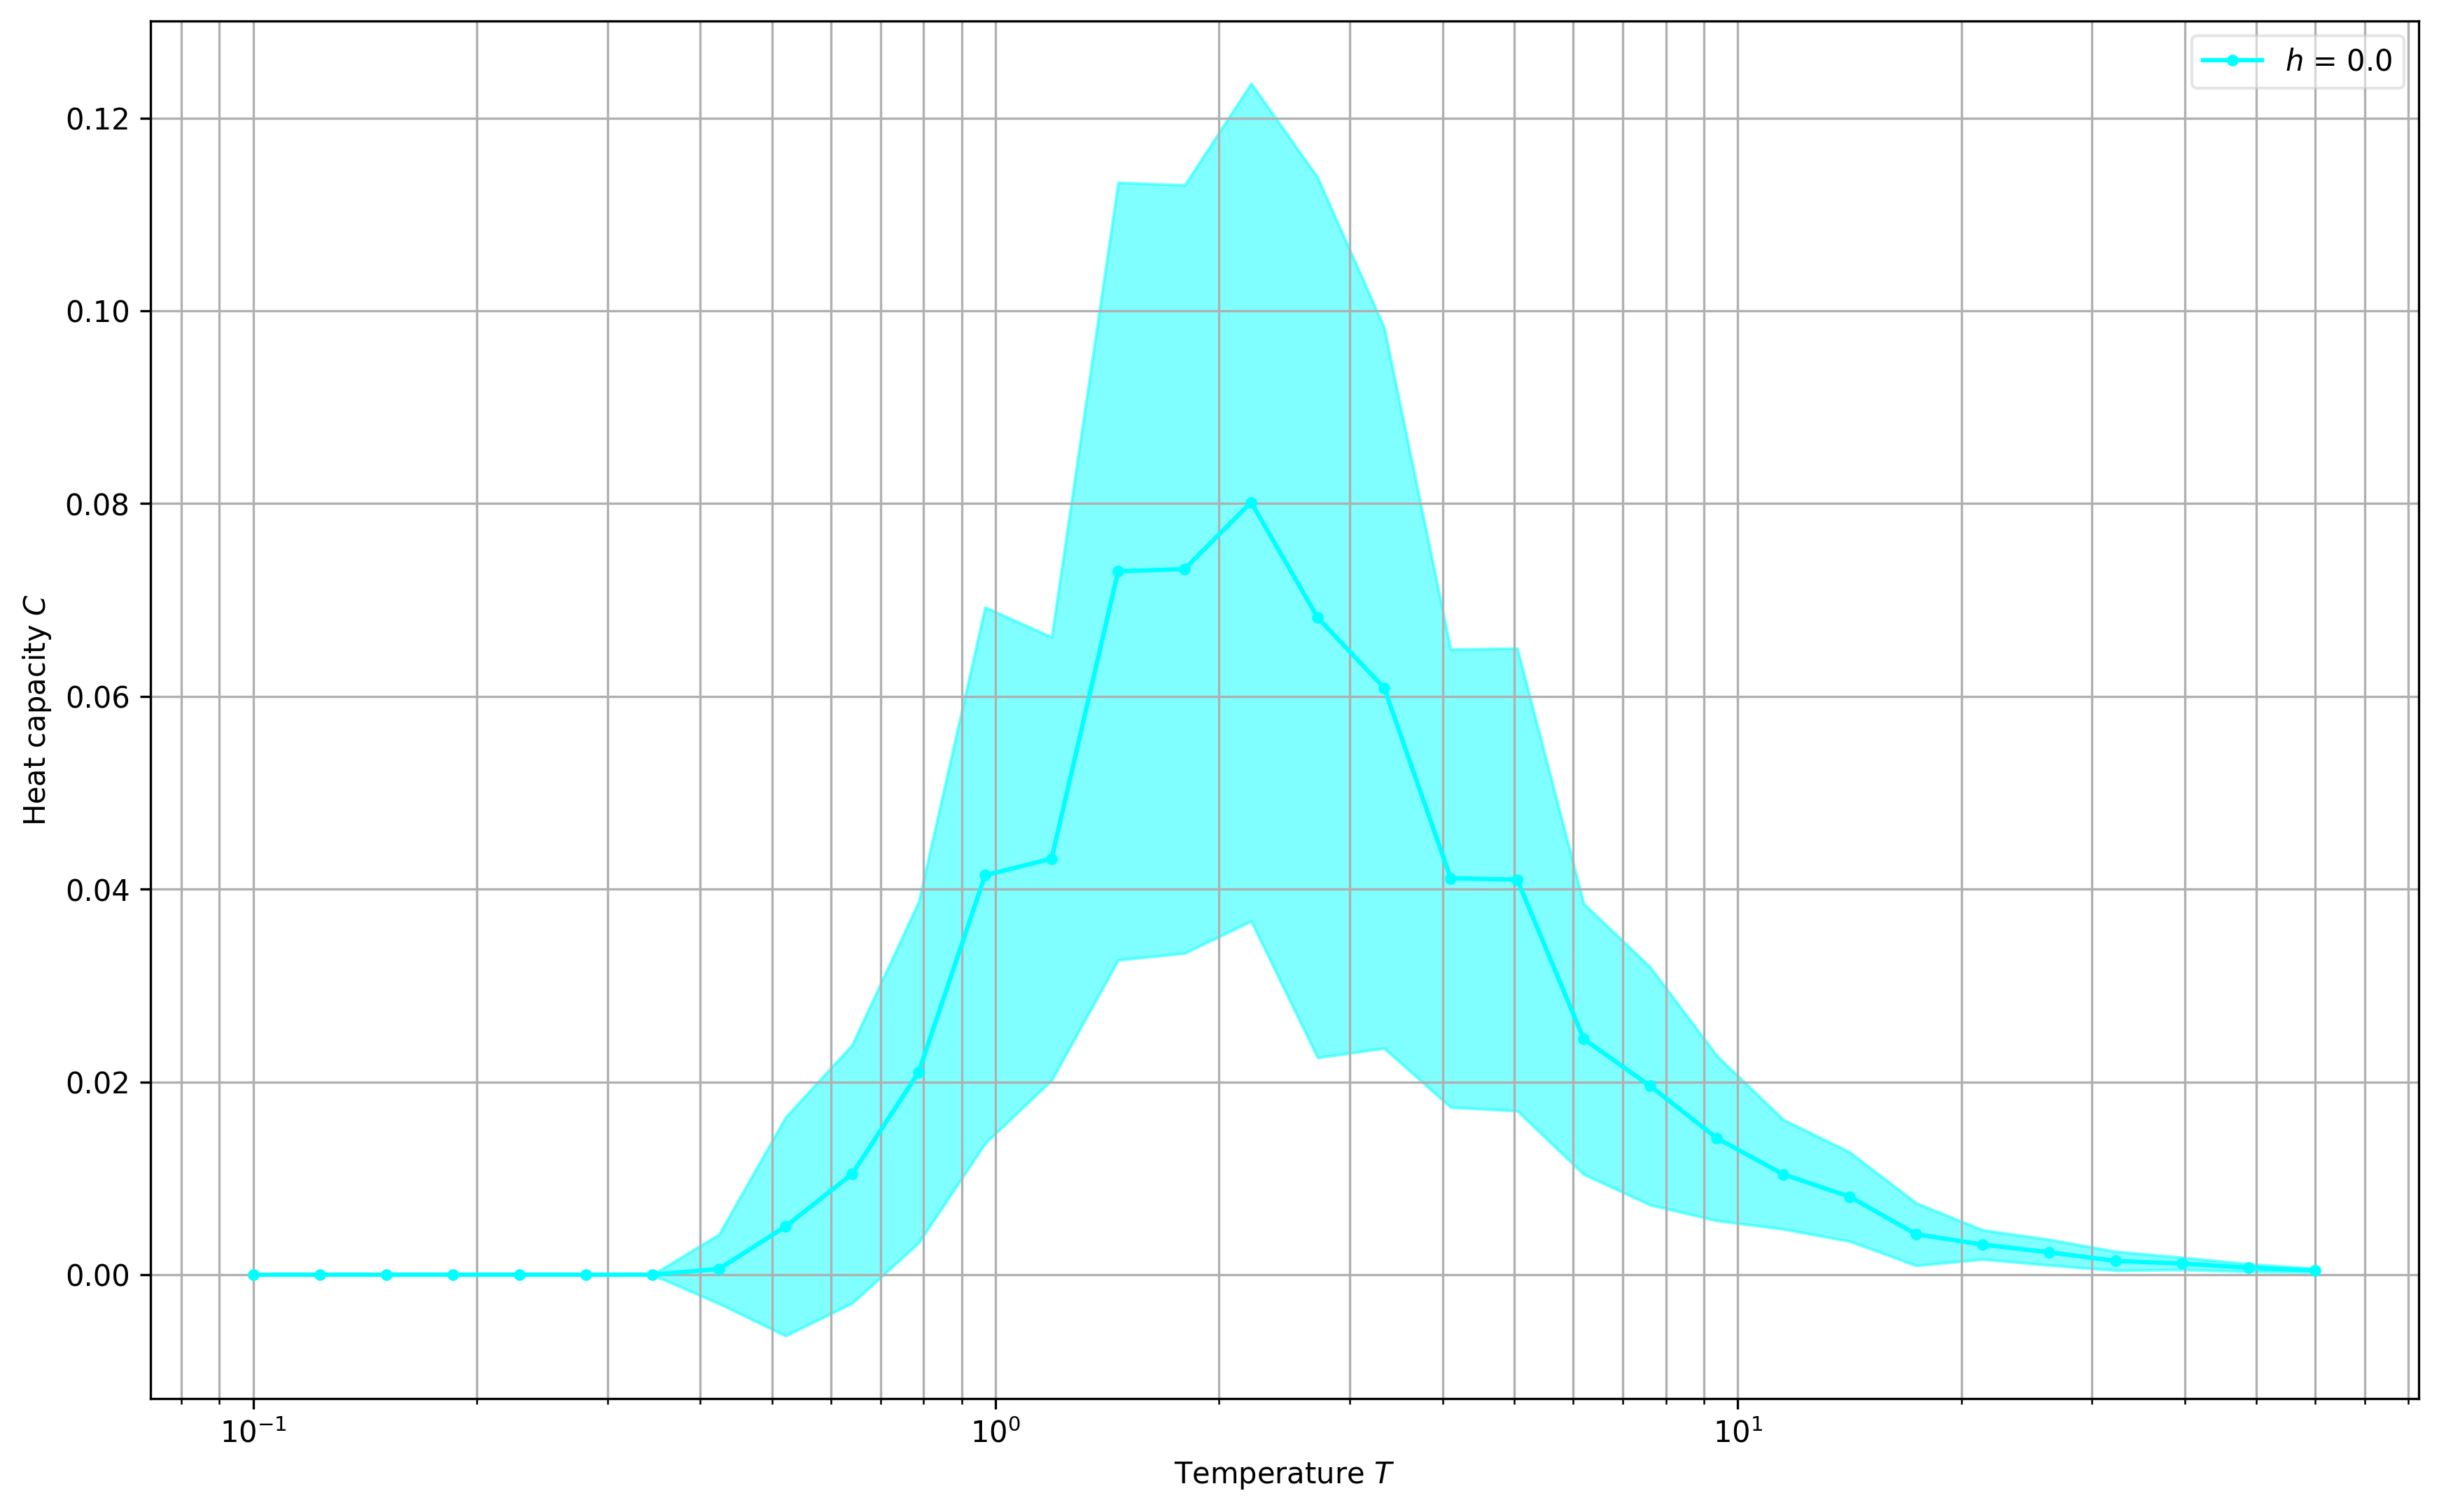

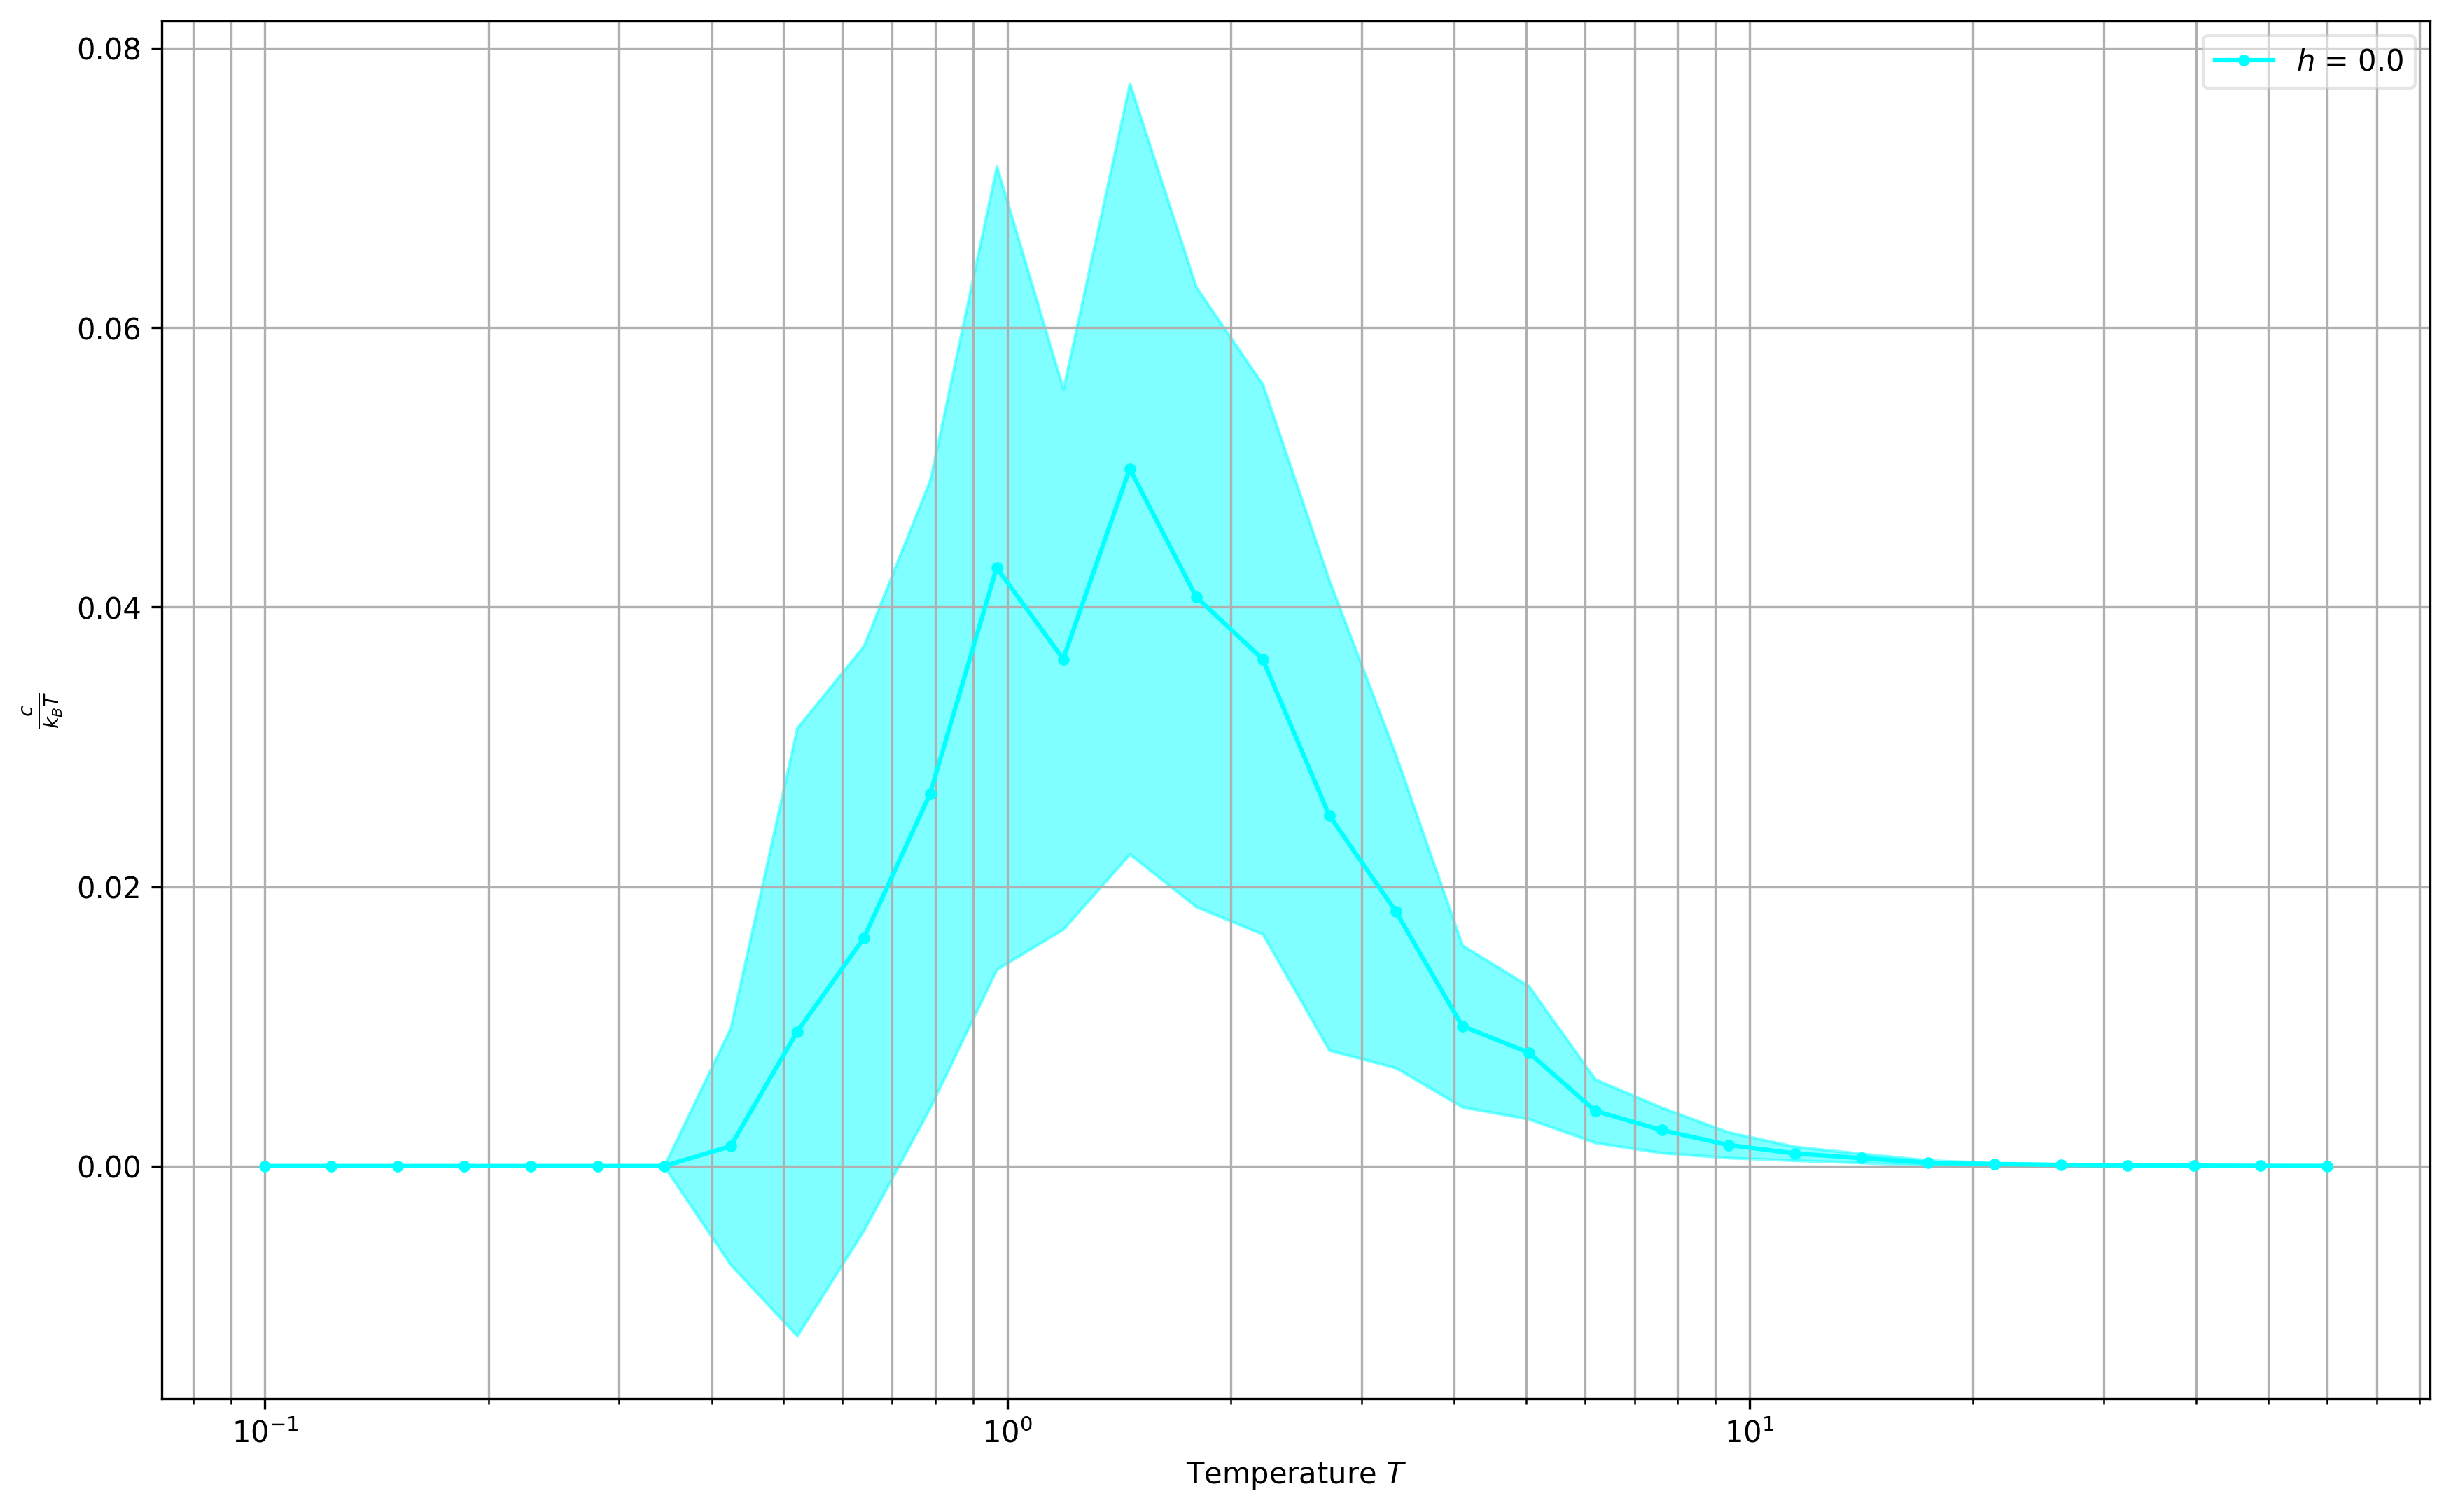

In [10]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsE(L,0, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
                t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kw)
plt.show()

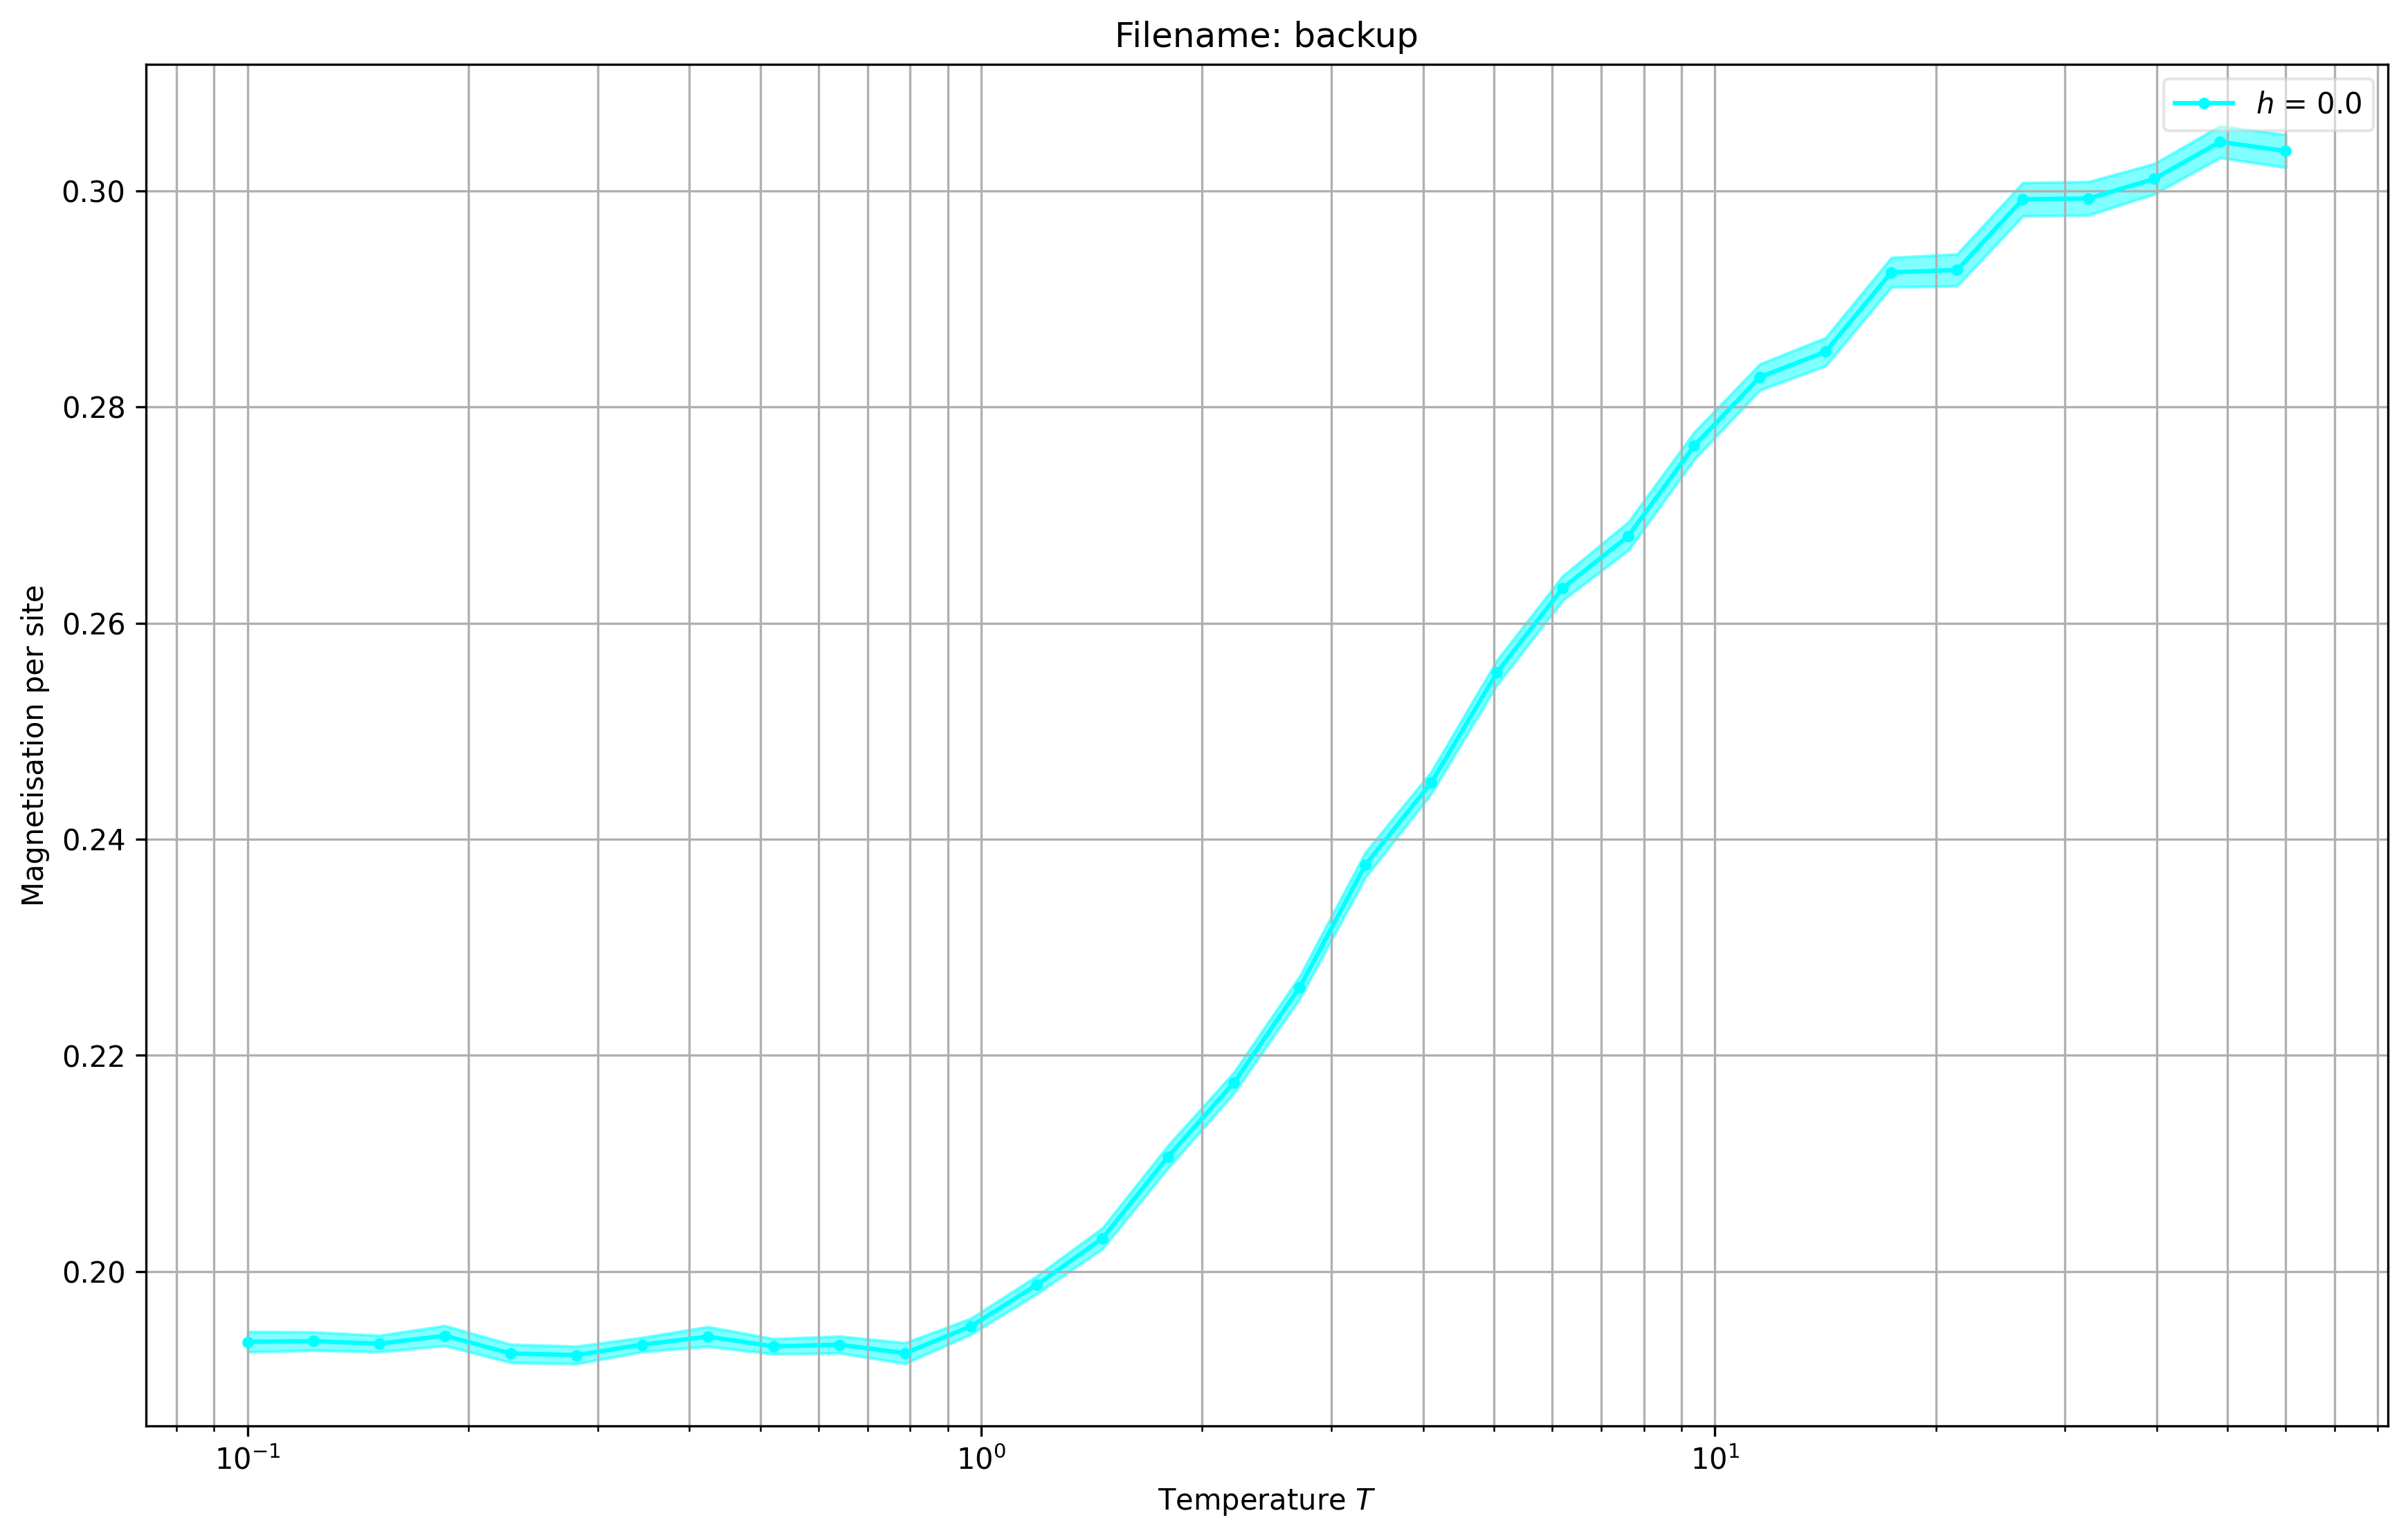

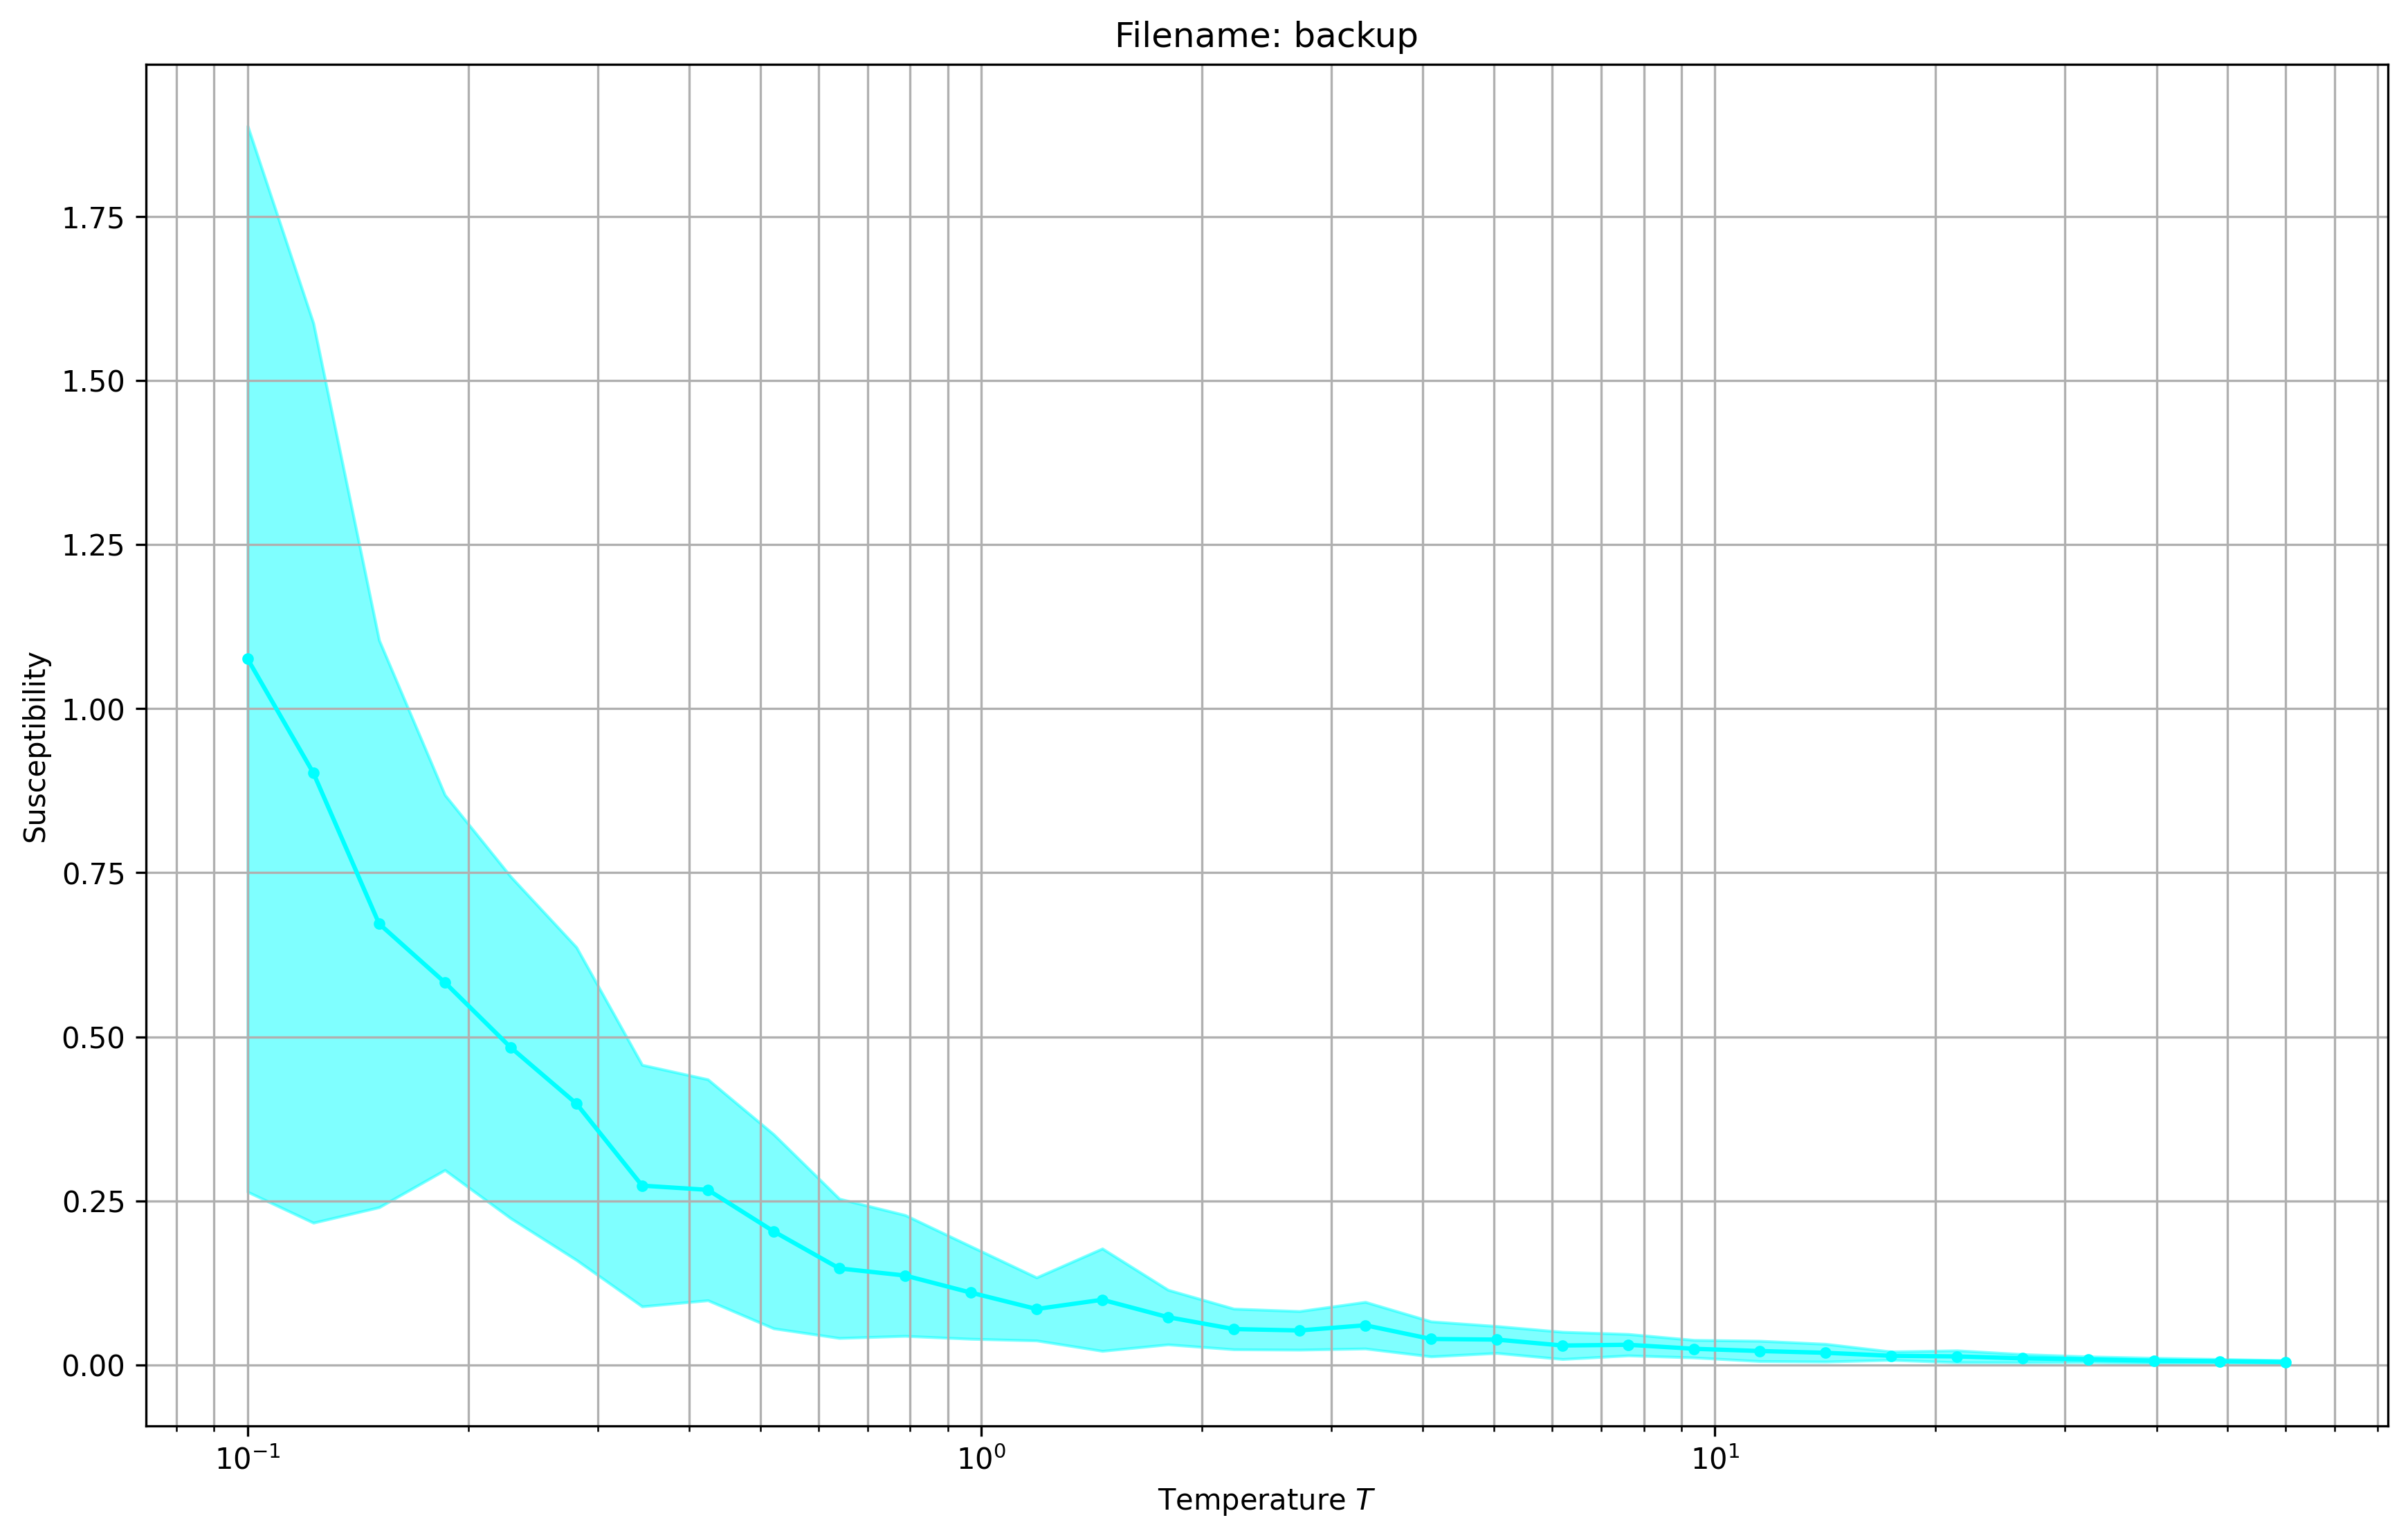

In [11]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanM, t_h_MeanMsq, t_h_varMeanM, t_h_varMeanMsq, Chi, ErrChi] = \
 af.LoadMagnetisation(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsM(L, 0, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanM, t_h_MeanMsq, t_h_varMeanM,
                t_h_varMeanMsq, Chi, ErrChi, J1, J2, J3, J4, **kw)
plt.show()

In [12]:
rmmag = True

In [13]:
kw = {'rmmag':rmmag}
t_h_MeanFc, t_h_varMeanFc, t_h_MeanSi, t_h_varMeanSi= \
 af.LoadFirstCorrelations(foldername, filenamelist, listfunctions, 
                          stat_temps, stat_hfields, nb,t_h_varMeanMsq, **kw)


(32, 1, 4)
(32, 1, 576)


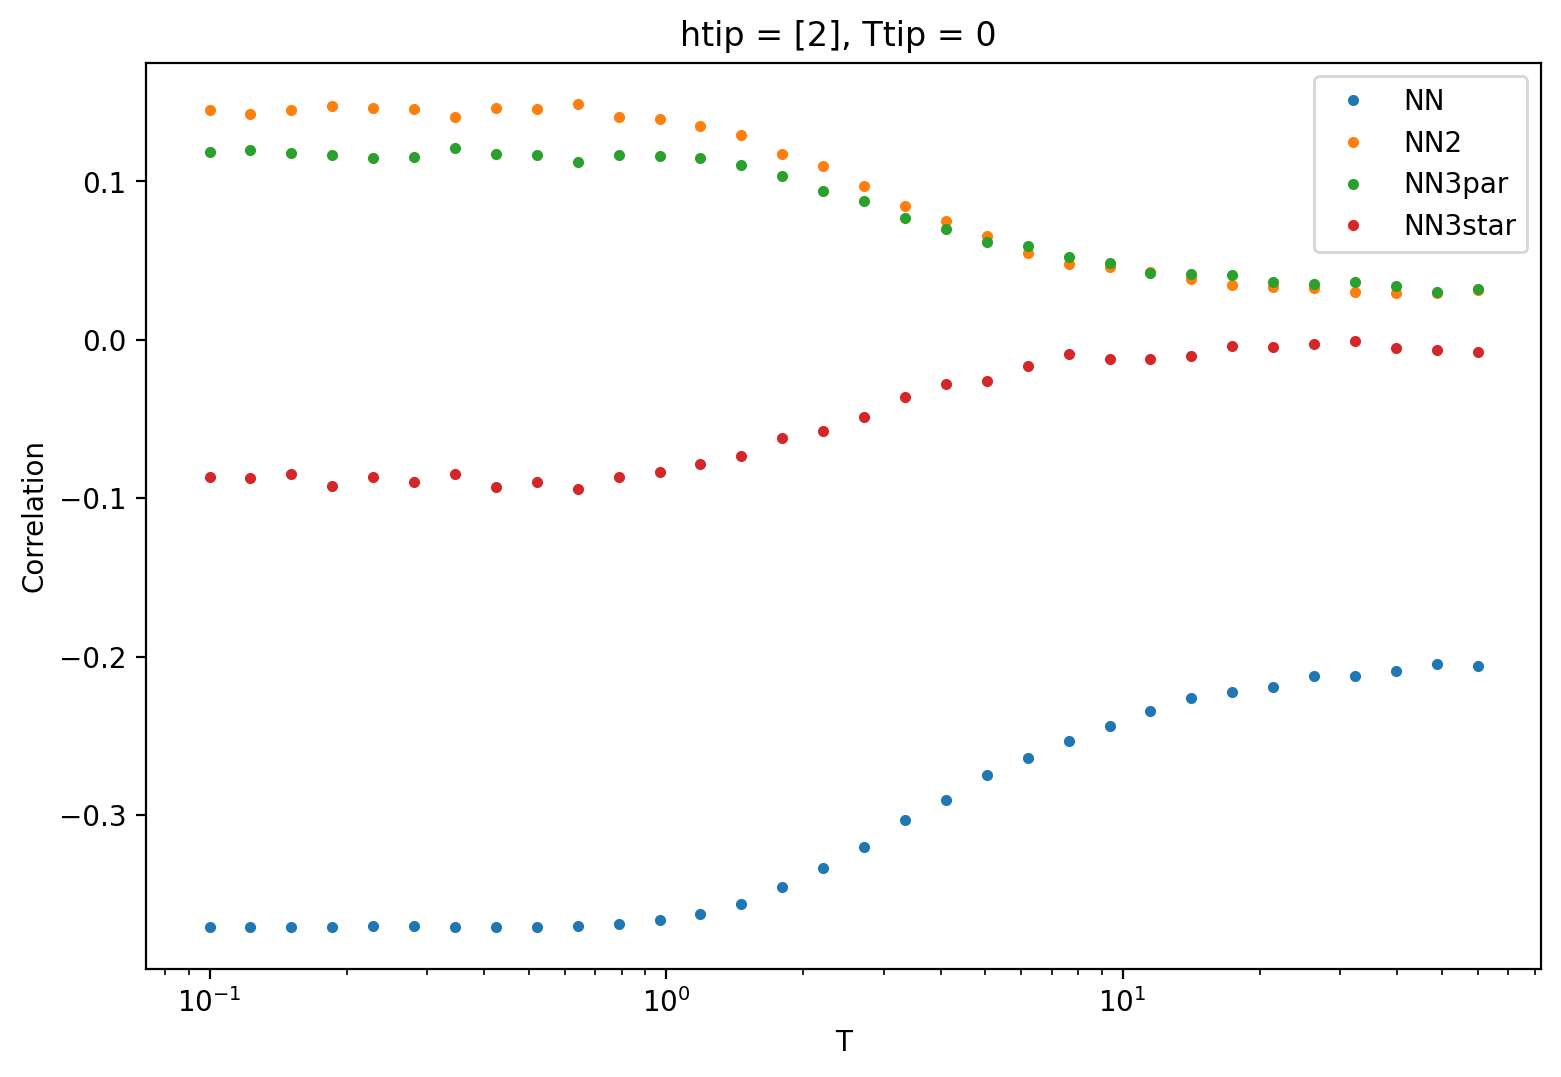

In [14]:
plt.figure(figsize = (9,6), dpi = 200)
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,0],'.',label = 'NN')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,1],'.',label = 'NN2')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,2],'.',label = 'NN3par')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,3],'.',label = 'NN3star')
plt.title("htip = {0}, Ttip = {1} ".format(htip, ttip))
plt.xlabel("T")
plt.ylabel("Correlation")
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/FirstCorrelations_rmmag{0}.png".format(rmmag))

In [15]:
kw = {'rmmag': rmmag}
t_h_MeanSs, t_h_varMeanSs, t_h_MeanSi, t_h_varMeanSi, t_h_MeanCorr, t_h_errCorrEstim = \
 af.LoadCentralCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)

In [16]:
### COMPUTING CORRELATIONS FROM <SISJ> AND <SI> and plotting in 2D
ploth = False
if not ploth:
    tid = 0
    hid = 0
    rid = tid
else:
    tid = 9
    hid = 15
    rid = hid

#[corr, errcorr, maxerr] = af.PrepPlot2DCorrelations(rid, n, 
#                                                t_h_MeanCorr,
#                                                t_h_errCorrEstim,
#                                                t_h_MeanSi,
#                                                hfields_plots,
#                                                temperatures_plots,\
#                                                ploth = ploth)
print("t = ",temperatures_plots[0][tid])
print("h = ",hfields_plots[0][hid])

t =  0.1
h =  0.0


[-0.37827047  0.15307109  0.09760539 -0.06874593]


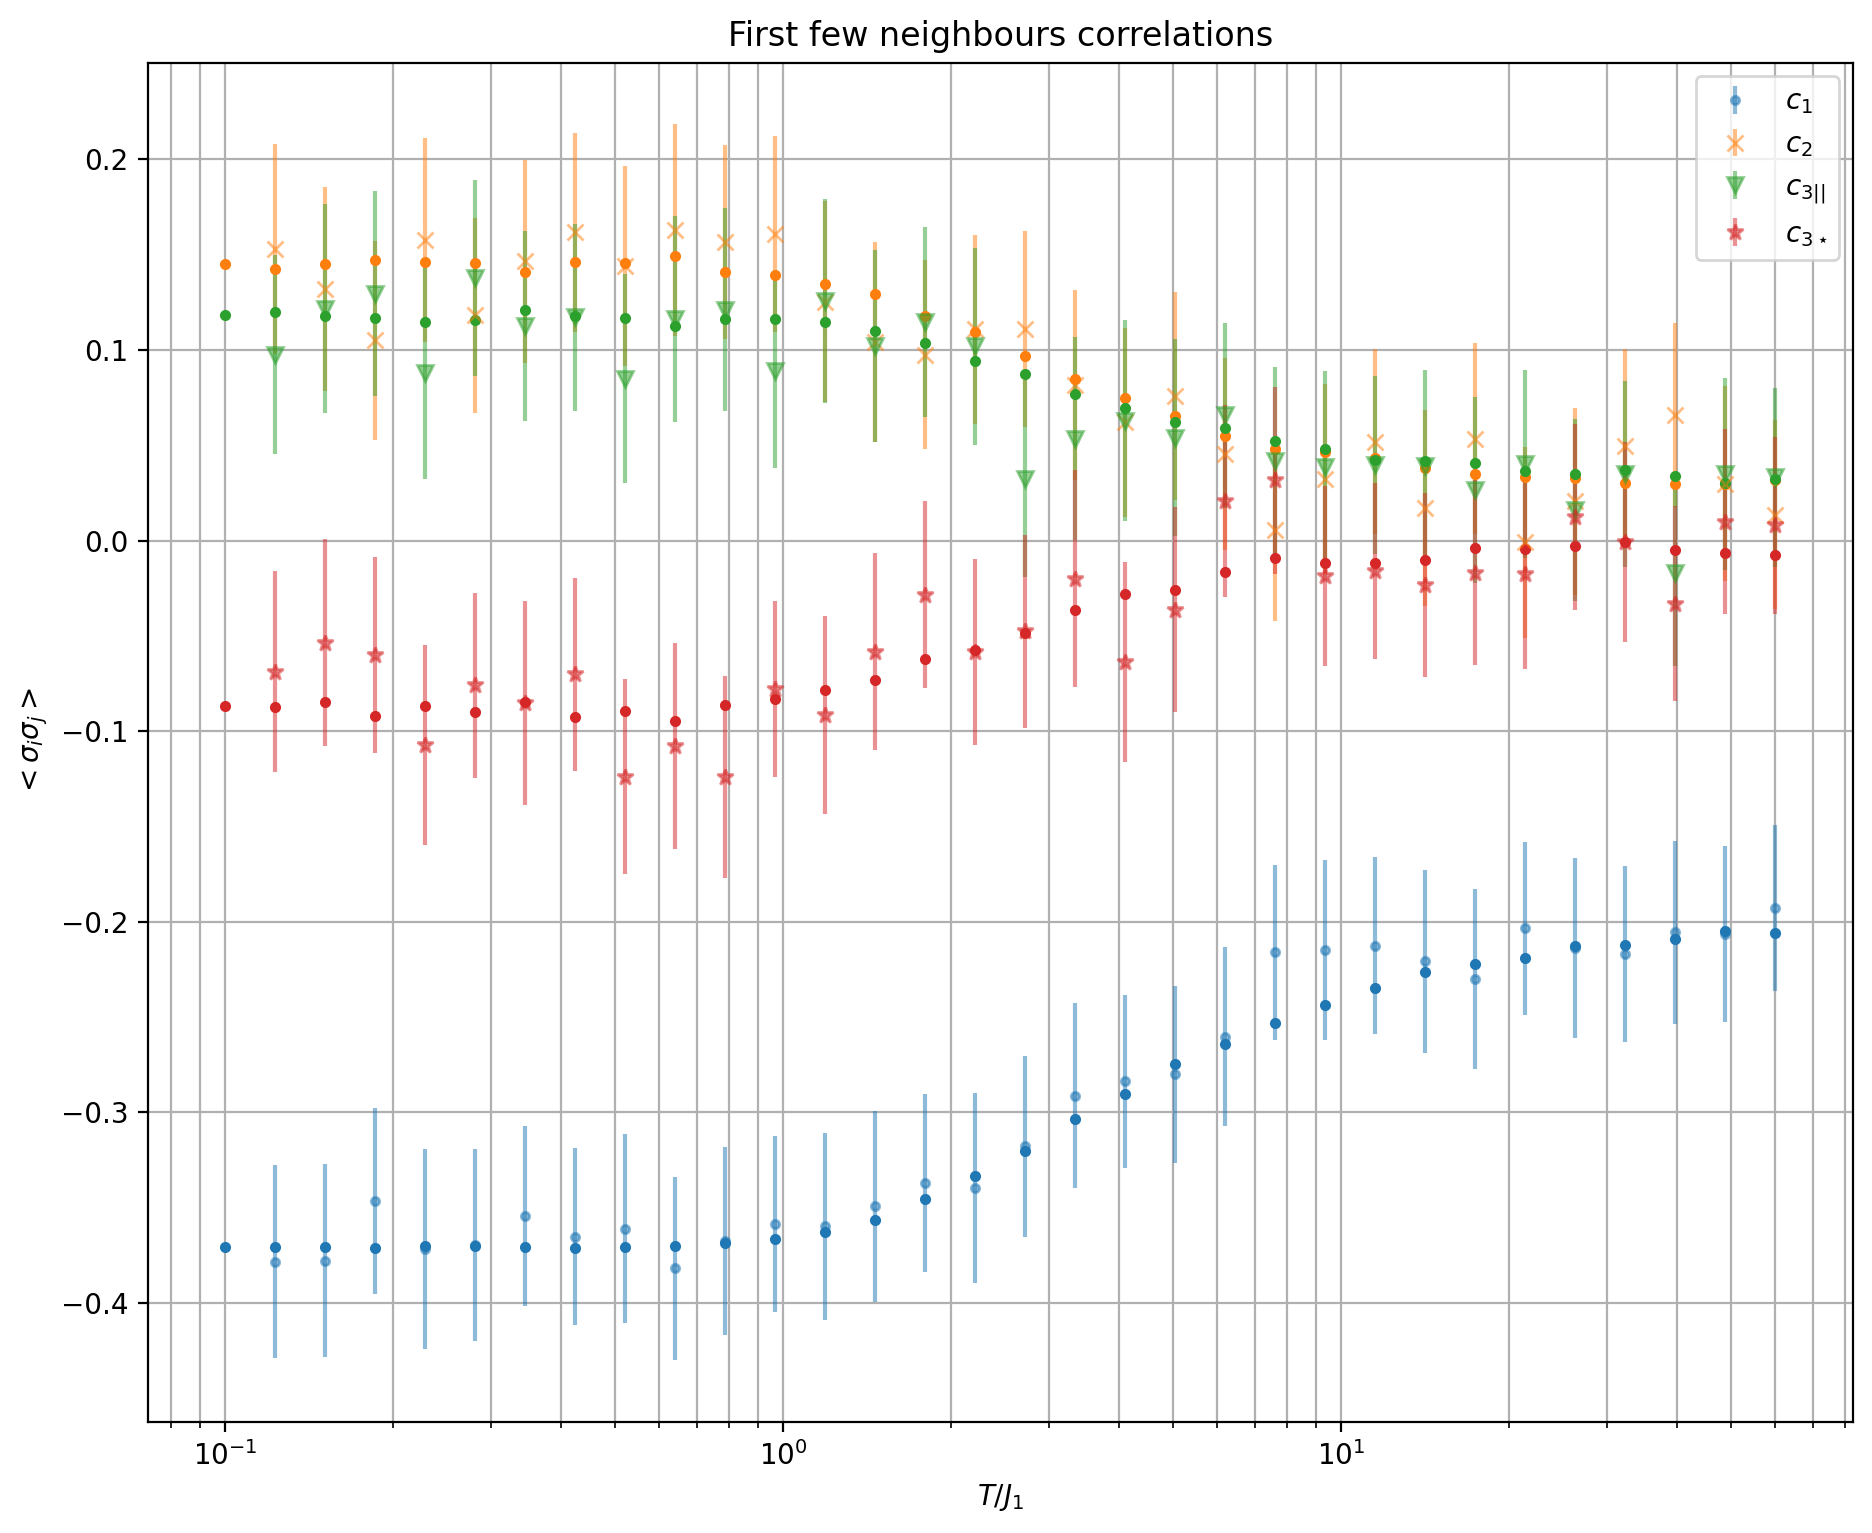

In [17]:
af.PlotFirstCorrelations(0, L,foldername, results_foldername, 
                         hfields_plots, temperatures_plots,
                         t_h_MeanCorr, t_h_errCorrEstim, sref,\
                         distmax = 2, ploth = ploth,
                         plotFirst = True, t_h_MeanFc = t_h_MeanFc)